# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


# Importing packages

In [ ]:
# General packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# Scoring methods
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

# Preprocessing steps
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import decomposition

# Visualisation
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

# Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [ ]:
## Data loading functions. Uncomment the one you want to use
from worclipo.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 115
The number of columns: 494


## Creating a split in the data

A training and test set are created. The training set will be used to fit the classifier, while the test set is remained untouched until it is used for testing the trained classifier.

Split is stratified so labels are present in both sets in same proportions.

In [ ]:
# Extract columns with labels
Y = data.pop('label').replace({'lipoma':0, 'liposarcoma':1}) #moeten we misschien nog ook de ID poppen?
print(f'The proportion of the labels is: {sum(Y)/len(Y)}')

# Extract the rest of the data (without the labels)
X = data
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, stratify=Y)

print(f'Size of training set: {X_train.shape}')
print(f'Size of test set: {X_test.shape}')

The proportion of the labels is: 0.5043478260869565
Size of training set: (92, 493)
Size of test set: (23, 493)


## Inspecting distribution of features
To determine data distribution of train set

### Visually inspect distribution of features

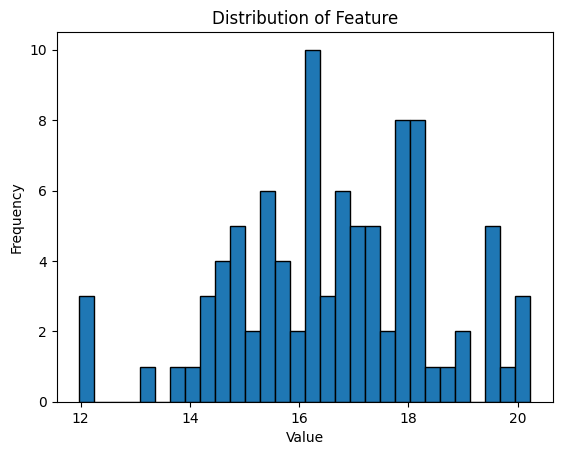

In [ ]:
## UITEINDELIJK WEGHALEN DIT!!

#Check if Gaussian distribution per column
# if Gaussian distribution, take mean for filling empty cells (later in script)
# if not Gaussion distribution (and outliers or skewed), take median for filling empty cells (later in script)

# plt.hist(X_train.iloc[:, 15], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)
plt.hist(X_train['PREDICT_original_tf_Gabor_entropy_F0.2_A1.57'], bins=30, edgecolor='k') # Change number of colum to see distribution (between width dataframe)


plt.title('Distribution of Feature')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

# print(X_train.head())

## Preprocessing Data

### Missing Values
Determining cells with missing values and filling these

In [ ]:
# Filling missing values with correct value based on type of distribution per column

alpha = 0.05
normal_distributed_columns_count_train = 0
not_normal_distributed_columns_count_train = 0
nans_found_in_column_count_train = 0


# Checking and filling missing for train
for column in X_train:
    if X_train[column].min() != X_train[column].max():
        stat, p = shapiro(X_train[column].dropna())
        if p > alpha:
            normal_distributed_columns_count_train += 1
            if X_train[column].isna().sum() > 0:
                X_train[column].fillna(X_train[column].mean(), inplace=True)
                nans_found_in_column_count_train += 1
        else:
            not_normal_distributed_columns_count_train += 1
            if X_train[column].isna().sum() > 0:
                X_train[column].fillna(X_train[column].median(), inplace=True)
                nans_found_in_column_count_train += 1

print(f'The number of normal distributed columns in train set is : {normal_distributed_columns_count_train}')
print(f'The number of not normal distributed columns in train set is: {not_normal_distributed_columns_count_train}')
print(f'The number of columns in train set where nans were filled: {nans_found_in_column_count_train}')
print()

# Checking and filling missing for test set
normal_distributed_columns_count_test = 0
not_normal_distributed_columns_count_test = 0
nans_found_in_column_count_test = 0

for column in X_test:
    if X_test[column].min() != X_test[column].max():
        stat, p = shapiro(X_test[column].dropna())
        if p > alpha:
            normal_distributed_columns_count_test += 1
            if X_test[column].isna().sum() > 0:
                X_test[column].fillna(X_train[column].mean(), inplace=True)
                nans_found_in_column_count_test += 1
        else:
            not_normal_distributed_columns_count_test += 1
            if X_test[column].isna().sum() > 0:
                X_test[column].fillna(X_train[column].median(), inplace=True)
                nans_found_in_column_count_test += 1

print(f'The number of normal distributed columns in test set is : {normal_distributed_columns_count_test}')
print(f'The number of not normal distributed columns in test set is: {not_normal_distributed_columns_count_test}')
print(f'The number of columns in test set where nans were filled: {nans_found_in_column_count_test}')

The number of normal distributed columns is: 90
The number of not normal distributed columns is: 403
The number of columns where nans were filled: 0


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


### Feature Scaling
Scale features in Train set

#### Motivation of chosen scaler

In [ ]:
# Calculating prescence and number of outliers
columns_many_outliers_count = 0

for column in X_train:
    Q1 = X_train[column].quantile(0.25)
    Q3 = X_train[column].quantile(0.75)
    IQR = Q3 - Q1

    outliers = X_train[(X_train[column] < (Q1 - 1.5 * IQR)) | (X_train[column] > (Q3 + 1.5 * IQR))]
    outliers_count = outliers.shape[0]

    if outliers_count > 0.05 * X_train.shape[0]:
        columns_many_outliers_count += 1

perc_columns_many_outliers = (columns_many_outliers_count / len(X_train.columns))*100
print(f"Number of columns with many outliers: {columns_many_outliers_count}/{len(X_train.columns)} = {perc_columns_many_outliers:.2f}%")

Number of columns with many outliers: 191/493


#### Scaling the data

In [ ]:
scaler = RobustScaler()
scaler.fit(X_train) # Fit scaler on training set

# Transform train and test set using scaler
X_train_sc = (scaler.transform(X_train))
X_test_sc = scaler.transform(X_test)

X_train_sc = pd.DataFrame(X_train_sc)
X_test_sc = pd.DataFrame(X_test_sc)

# Inspecting data

### Feature selection and extraction

In [ ]:
# Determining features with zero variance and removing these
selector = VarianceThreshold(threshold=0)
vs_fit = selector.fit(X_train_sc)

X_train_zv = vs_fit.transform(X_train_sc)
X_test_zv = vs_fit.transform(X_test_sc)

# Willen we dit nou van train of test set weten?
print(f'Amount of features with zero variance: {X_train_sc.shape[1]-X_train_zv.shape[1]}')
print(f'Amount of features after removing features with zero variance: {X_train_zv.shape[1]}')

Amount of features with zero variance: 22
Amount of features after removing features with zero variance: 471


In [ ]:
# Evaluating performance of selectkbest feature selection on data set

kf = StratifiedKFold(n_splits=10)
k_values = range(1, 11)
average_accuracies = []
std_accuracies = []

for k in k_values:

    # Select K-best features
    selector = SelectKBest(f_classif, k=k)
    X_train_select = selector.fit_transform(X_train_zv, Y_train)
    accuracies = []

    # 10-fold cross-validation
    for train_index, test_index in kf.split(X_train_select, Y_train):

        X_fold_train, X_fold_test = X_train_select[train_index], X_train_select[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        # Train kNN-model
        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        # Predict and evaluate accuracy
        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    # Calculating average accuracy for current k-number
    average_accuracy = np.mean(accuracies)
    average_accuracies.append(average_accuracy)

    # Calculating standard deviation accuracy for current k-number
    std_accuracy = np.std(accuracies)
    std_accuracies.append(std_accuracy)

    print(f"For k={k} average accuracy is {average_accuracy:.3f} and standard deviation is {std_accuracy:.3f}")

upper_bound = np.array(average_accuracies) + np.array(std_accuracies)
lower_bound = np.array(average_accuracies) - np.array(std_accuracies)

plt.figure(figsize=(10,6))
plt.plot(list(k_values), average_accuracies, marker='o', linestyle='-', color='blue', label='Average accuracy')
plt.fill_between(list(k_values), upper_bound, lower_bound, label='Standard deviation of accuracy')
plt.title('Average accuracy vs no. of K-features for K-Best')
plt.xlabel('No. of features')
plt.ylabel('Average accuracy')
plt.grid(True)
plt.xticks(list(k_values))
plt.legend()
plt.show()


(92, 5)
(23, 5)


In [ ]:
# Evaluating performance of PCA on dataset

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
components = range(1, 11)
average_accuracies = []
std_accuracies = []
plot_proberen = []

for n_components in components:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_zv)
    variance = pca.explained_variance_ratio_

    if n_components == 2:
        plot_proberen.append(X_train_pca)

    accuracies = []

    for train_index, test_index in skf.split(X_train_pca, Y_train):
        X_fold_train, X_fold_test = X_train_pca[train_index], X_train_pca[test_index]
        y_fold_train, y_fold_test = Y_train.iloc[train_index], Y_train.iloc[test_index]

        knn_model = KNeighborsClassifier()
        knn_model.fit(X_fold_train, y_fold_train)

        predictions = knn_model.predict(X_fold_test)
        accuracy = accuracy_score(y_fold_test, predictions)
        accuracies.append(accuracy)

    average_accuracy = np.mean(accuracies)
    average_accuracies.append(average_accuracy)
    std_dev = np.std(accuracies)
    std_accuracies.append(std_dev)

    print(f"n-components = {n_components}, average accuracy = {average_accuracy:.3f} with std dev = {std_dev:.3f}")

print(f'Explained variance for the first element {variance[0]}')

upper_bound = np.array(average_accuracies) + np.array(std_accuracies)
lower_bound = np.array(average_accuracies) - np.array(std_accuracies)

plt.figure(figsize=(10, 6))
plt.plot(list(components), average_accuracies, marker='o', linestyle='-', color='blue', label='Average accuracy')
plt.fill_between(list(components), upper_bound, lower_bound, label='Standard deviation')
plt.title('Average accuracy vs no. of components for PCA')
plt.xlabel('No. of components')
plt.ylabel('Average accuracy')
plt.grid(True)
plt.xticks(list(components))
plt.legend()
plt.show()

In [ ]:
# Applying dimensionality reduction technique with best performance on dataset
print(X_train_zv.shape)
print(X_test_zv.shape)

selector_fs = SelectKBest(f_classif, k=2) #dit veranderen ahv plot

fitted_kbest = selector_fs.fit(X_train_zv, Y_train)

X_train_fs = fitted_kbest.transform(X_train_zv)
X_test_fs = fitted_kbest.transform(X_test_zv)

print(X_train_fs.shape)
print(X_test_fs.shape)

feature1 = X_train_fs[:, 0]
feature2 = X_train_fs[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(feature1, feature2, c=Y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label='Target')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Selected Features')
plt.grid(True)
plt.show()

# Classifiers

In [ ]:
def plot_learning_curve(estimator, title, X, Y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    '''plotting learning curve'''

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, Y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="lower center")

    return plt

### KNN

In [ ]:
# Define cv and knn classifier
cv_knn = 6
knn_model = KNeighborsClassifier()

# Define range for n neighbours to be max the size of one split
max_n_neighbors = len(X_train_fs) // cv_knn - 1
print("Max number of neighbors:", max_n_neighbors)

# Define the parameter grid
param_grid_knn = {
    'n_neighbors': list(range(1, max_n_neighbors, 2)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Create the grid search object with ROC AUC scoring
grid_search_knn = GridSearchCV(knn_model, param_grid_knn, cv=cv_knn, scoring='roc_auc')

# Fit the grid search to the data
grid_search_knn.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_knn.best_params_)

# Get the best estimator
best_knn_model = grid_search_knn.best_estimator_
print(f'Best estimator: {best_knn_model}')

# See how well model works on train data:
pred_knn_train = best_knn_model.predict(X_train_fs)
pred_proba_knn_train = best_knn_model.predict_proba(X_train_fs)[:,1]

roc_auc_knn_train = roc_auc_score(Y_train, pred_proba_knn_train)
print('ROC AUC train =', roc_auc_knn_train)
accuracy_knn_train = accuracy_score(Y_train, pred_knn_train)
print('Accuracy train =', accuracy_knn_train)

# See how well model works on test data:
pred_knn_test = best_knn_model.predict(X_test_fs)
pred_proba_knn_test = best_knn_model.predict_proba(X_test_fs)[:,1]

roc_auc_knn_test = roc_auc_score(Y_test, pred_proba_knn_test)
print('ROC AUC test =', roc_auc_knn_test)
accuracy_knn_test = accuracy_score(Y_test, pred_knn_test)
print('Accuracy test =', accuracy_knn_test)

Max number of neighbors: 14
Best parameters found:  {'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')
ROC AUC train = 1.0
Accuracy train = 1.0
ROC AUC test = 0.8863636363636364
Accuracy test = 0.7391304347826086


### Random forest

Maximum ROC AUC: 0.9242424242424242 at n_estimators = 18
Best parameters found:  {'bootstrap': False, 'min_samples_leaf': 5}
RandomForestClassifier(bootstrap=False, min_samples_leaf=5, n_estimators=15)
ROC AUC train= 0.9929111531190925
Accuracy train= 0.9130434782608695
ROC AUC test= 0.8863636363636364
Accuracy test= 0.8260869565217391


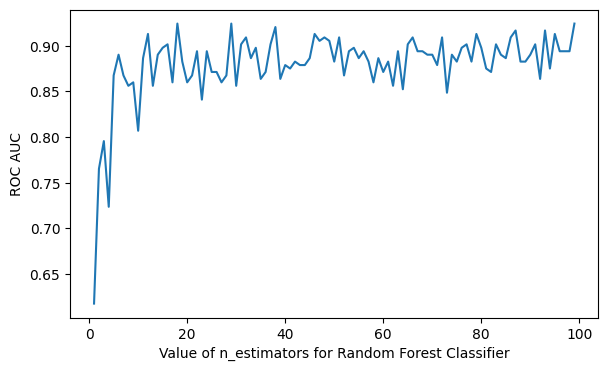

In [ ]:
# Visualise the effect of n_estimators
roc_auc_scores = []

for k in range(1, 100):
    rf_model = RandomForestClassifier(n_estimators=k)
    rf_model.fit(X_train_fs, Y_train)

    pred_proba_RF_test =rf_model.predict_proba(X_test_fs)[:,1]
    roc_auc_RF_test = roc_auc_score(Y_test, pred_proba_RF_test)
    roc_auc_scores.append(roc_auc_RF_test)

# Plot the relationship between K and testing roc auc
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(range(1, 100), roc_auc_scores)
plt.xlabel('Value of n_estimators for Random Forest Classifier')
plt.ylabel('ROC AUC')

# Find the index of the (first) maximum ROC AUC score
max_roc_auc_index = np.argmax(roc_auc_scores)

# Find the maximum ROC AUC score and its corresponding n_estimators
max_roc_auc = roc_auc_scores[max_roc_auc_index]
best_n_estimators_roc_auc = max_roc_auc_index + 1  # Adding 1 to convert index to n_estimators value

# Print the results
print("Maximum ROC AUC:", max_roc_auc, "at n_estimators =", best_n_estimators_roc_auc)

# The model shows there is a lot of variety in which estimator is best
# But since it is best to use a more simple model (with the same results)
# We choose n_estimators = 15

# Define cv and RF classifier
cv_RF = 7
RF_model = RandomForestClassifier(n_estimators=15)

# Define the parameter grid
param_grid_RF = {
    'bootstrap': [True, False],
    'min_samples_leaf': list(range(1, 7, 2))
}

# Create the grid search object with ROC AUC scoring
grid_search_RF = GridSearchCV(RF_model, param_grid_RF, cv=cv_RF, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_RF.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_RF.best_params_)

# Get the best estimator
best_RF_model = grid_search_RF.best_estimator_
print(best_RF_model)

# See how well model works on train data:
pred_RF_train = best_RF_model.predict(X_train_fs)
pred_proba_RF_train = best_RF_model.predict_proba(X_train_fs)[:,1]

roc_auc_RF_train = roc_auc_score(Y_train, pred_proba_RF_train)
print('ROC AUC train=', roc_auc_RF_train)
accuracy_RF_train = accuracy_score(Y_train, pred_RF_train)
print('Accuracy train=', accuracy_RF_train)

# See how well model works on test data:
pred_RF_test = best_RF_model.predict(X_test_fs)
pred_proba_RF_test = best_RF_model.predict_proba(X_test_fs)[:,1]

roc_auc_RF_test = roc_auc_score(Y_test, pred_proba_RF_test)
print('ROC AUC test=', roc_auc_RF_test)
accuracy_RF_test = accuracy_score(Y_test, pred_RF_test)
print('Accuracy test=', accuracy_RF_test)

### Support Vector Machine

In [ ]:
# Define cv and SVM classifier
cv_svm = 5
svm_model = svm.SVC(probability=True)

# Define the parameter grid for SVM
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'linear', 'poly'] # Kernel type
}

# Create the grid search object with ROC AUC scoring
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=cv_svm, scoring='roc_auc', error_score='raise')

# Fit the grid search to the data
grid_search_svm.fit(X_train_fs, Y_train)

# Print the best parameters
print("Best parameters found: ", grid_search_svm.best_params_)

# Get the best estimator
best_svm_model = grid_search_svm.best_estimator_
print(best_svm_model)

# See how well model works on train data
pred_svm_train = best_svm_model.predict(X_train_fs)
pred_proba_svm_train = best_svm_model.decision_function(X_train_fs)

roc_auc_svm_train = roc_auc_score(Y_train, pred_proba_svm_train)
print('ROC AUC train=', roc_auc_svm_train)
accuracy_svm_train = accuracy_score(Y_train, pred_svm_train)
print('Accuracy train=', accuracy_svm_train)

# See how well model works on test data
pred_svm_test = best_svm_model.predict(X_test_fs)
pred_proba_svm_test = best_svm_model.decision_function(X_test_fs)

roc_auc_svm_test = roc_auc_score(Y_test, pred_proba_svm_test)
print('ROC AUC test=', roc_auc_svm_test)
accuracy_svm_test = accuracy_score(Y_test, pred_svm_test)
print('Accuracy test=', accuracy_svm_test)

Best parameters found:  {'C': 0.001, 'gamma': 'scale', 'kernel': 'linear'}
SVC(C=0.001, kernel='linear', probability=True)
ROC AUC train= 0.7986767485822307
Accuracy train= 0.6521739130434783
ROC AUC test= 0.8863636363636364
Accuracy test= 0.782608695652174


# Visualisatie

## Receiver Operating Curve

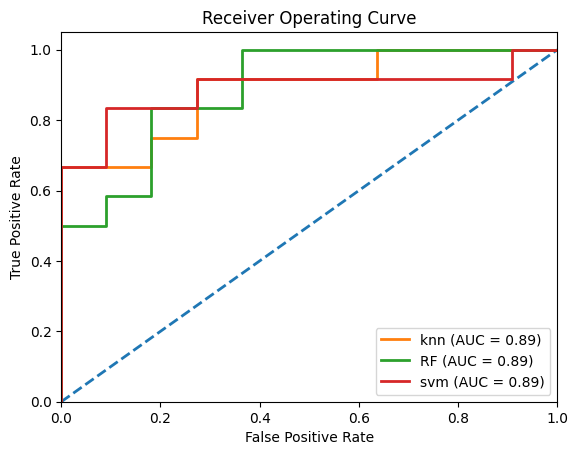

In [ ]:
# Plot the ROC curve of the different classifiers
plt.figure()
lw = 2
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Curve')

# knn
fpr_knn, tpr_knn, _ = roc_curve(Y_test, pred_proba_knn_test)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, lw=lw, label='knn (AUC = %0.2f)' % roc_auc_knn)

# RF
fpr_RF, tpr_RF, _ = roc_curve(Y_test, pred_proba_RF_test)
roc_auc_RF = auc(fpr_RF, tpr_RF)
plt.plot(fpr_RF, tpr_RF, lw=lw, label='RF (AUC = %0.2f)' % roc_auc_RF)

# svm
fpr_svm, tpr_svm, _ = roc_curve(Y_test, pred_proba_svm_test)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, lw=lw, label='svm (AUC = %0.2f)' % roc_auc_svm)

plt.legend(loc="lower right")
plt.show()

## Learning curves

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 373, in _score
    y_pred = method_caller(clf, "decision_function", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
AttributeError: 'KNeighborsClassifier' object has no attribute 'decision_function'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    retur

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

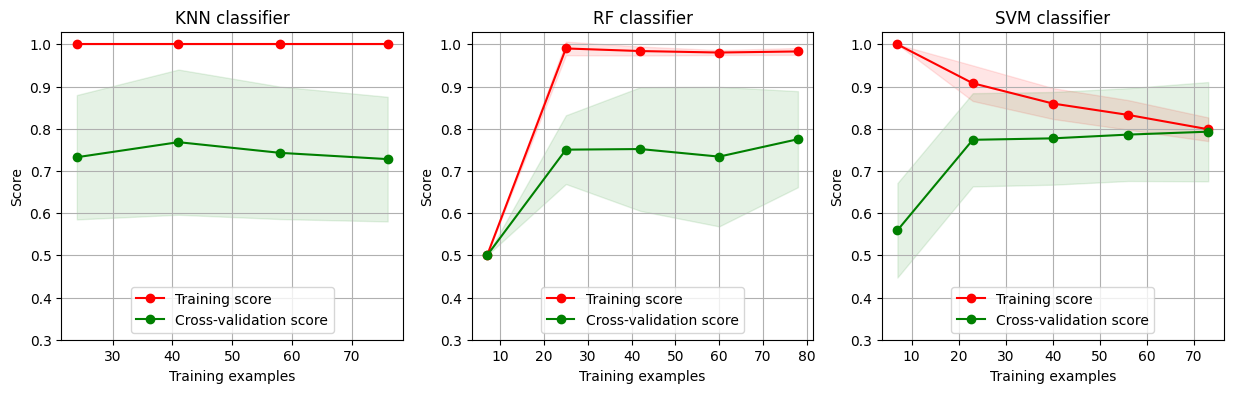

In [ ]:
fig = plt.figure(figsize=(15,4))

# knn
ax = fig.add_subplot(1, 3, 1)
plot_learning_curve(best_knn_model, 'KNN classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=cv_knn)

# RF
ax = fig.add_subplot(1, 3, 2)
plot_learning_curve(best_RF_model, 'RF classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=cv_RF)

# CVM
ax = fig.add_subplot(1, 3, 3)
plot_learning_curve(best_svm_model, 'SVM classifier', X_train_fs, Y_train, ax, ylim=(0.3, 1.03), cv=cv_svm)